In [1]:
import numpy as np
import pandas as pd

In [2]:
movies = pd.read_csv(r'C:/Users/madhumitha/Downloads/ml-latest-small/ml-latest-small/movies.csv')
genome_scores = pd.read_csv(r'C:/Users/madhumitha/Downloads/ml-latest-small/ml-latest-small/links.csv')
tags = pd.read_csv(r'C:/Users/madhumitha/Downloads/ml-latest-small/ml-latest-small/tags.csv')
genome_tags = pd.read_csv(r'C:/Users/madhumitha/Downloads/ml-latest-small/ml-latest-small/links.csv')
ratings = pd.read_csv(r'C:/Users/madhumitha/Downloads/ml-latest-small/ml-latest-small/ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.shape

(9742, 3)

In [5]:
len(movies['movieId'].unique())

9742

In [6]:
movies['genres'] = movies['genres'].str.replace('|', ' ')

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
genome_scores.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [9]:
genome_tags.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [10]:
genome_scores.shape

(9742, 3)

In [11]:
tags.head

<bound method NDFrame.head of       userId  movieId               tag   timestamp
0          2    60756             funny  1445714994
1          2    60756   Highly quotable  1445714996
2          2    60756      will ferrell  1445714992
3          2    89774      Boxing story  1445715207
4          2    89774               MMA  1445715200
...      ...      ...               ...         ...
3678     606     7382         for katie  1171234019
3679     606     7936           austere  1173392334
3680     610     3265            gun fu  1493843984
3681     610     3265  heroic bloodshed  1493843978
3682     610   168248  Heroic Bloodshed  1493844270

[3683 rows x 4 columns]>

In [12]:
tags.shape

(3683, 4)

In [13]:
genome_tags.shape

(9742, 3)

In [14]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [15]:
ratings.shape

(100836, 4)

In [16]:
len(ratings['movieId'].unique())

9724

In [17]:
#filtering and cleaning

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

In [18]:
len(ratings_f['movieId'].unique()) / len(movies['movieId'].unique()) * 100

98.7990145760624

In [19]:
len(ratings_f['userId'].unique()) / len(ratings['userId'].unique()) * 100

59.67213114754099

In [20]:
movie_list_rating = ratings_f.movieId.unique().tolist()

In [21]:
movies = movies[movies['movieId'].isin(movie_list_rating)]

In [22]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [23]:
movies.shape

(9625, 3)

In [24]:
Mapping_file = dict(zip(movies['title'].tolist(), movies['movieId'].tolist()))

In [25]:
tags.drop(['timestamp'], axis = 1, inplace = True)
ratings_f.drop(['timestamp'], axis = 1, inplace = True)

In [26]:
#Merge the movies and tags Data Frames

mixed = pd.merge(movies, tags, on = 'movieId', how = 'left')
mixed.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game


In [27]:
#Create Metadata from genres and tag Columns

mixed.fillna("", inplace = True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on = 'movieId', how = 'left')
Final['metadata'] = Final[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head()

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),pregnancy remake Comedy


In [28]:
#Creating a content latent matrix from movie metadata:

from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index = Final.index.tolist())
print(tfidf_df.shape)

(9625, 1675)


In [30]:
from sklearn.decomposition import TruncatedSVD    

In [31]:
svd = TruncatedSVD(n_components = 200)
latent_matrix = svd.fit_transform(tfidf_df)

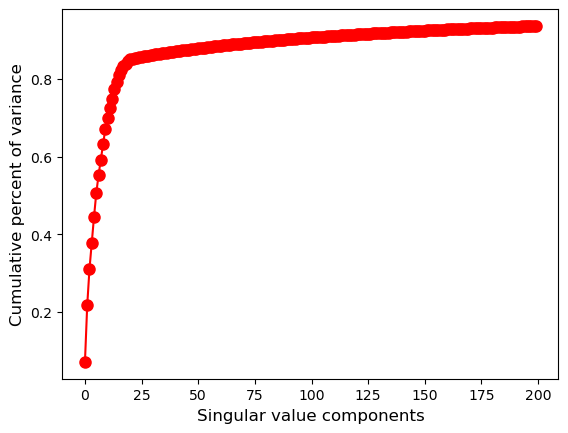

In [32]:
import matplotlib.pyplot as plt
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color ='red')
plt.xlabel('Singular value components', fontsize = 12)
plt.ylabel('Cumulative percent of variance', fontsize = 12)        
plt.show()

In [33]:
n = 200
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())
latent_matrix_1_df.shape

(9625, 200)

In [34]:
#Creating a collaborative latent matrix from user ratings:

ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [35]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on = "movieId", how = "right")


In [36]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
ratings_f2.head()


userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [37]:
svd = TruncatedSVD(n_components = 200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index = Final.title.tolist())


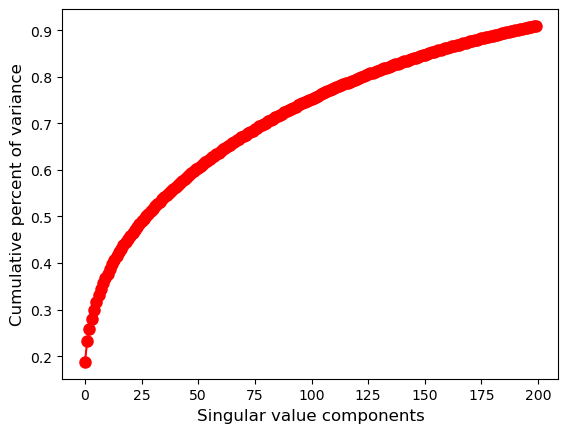

In [38]:
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color = 'red')
plt.xlabel('Singular value components', fontsize = 12)
plt.ylabel('Cumulative percent of variance', fontsize = 12)        
plt.show()


In [39]:
#Content/Collaborative and Hybrid cosine similarity

from sklearn.metrics.pairwise import cosine_similarity, linear_kernel


In [40]:
a_1 = np.array(latent_matrix_1_df.loc["Look Who's Talking (1989)"]).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Look Who's Talking (1989)"]).reshape(1, -1)


In [41]:
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)


In [42]:
hybrid = ((score_1 + score_2) / 2.0)


In [43]:
dictDf = {'content': score_1, 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)



In [44]:
similar.sort_values('content', ascending = False, inplace = True)
similar[1:].head(11)

,content,collaborative,hybrid
Jack and Sarah (1995),0.947319,0.184258,0.565788
"Truth About Cats & Dogs, The (1996)",0.578005,0.243143,0.410574
Better Off Dead... (1985),0.570267,0.130645,0.350456
Down with Love (2003),0.564006,0.079508,0.321757
"Goodbye Girl, The (1977)",0.563135,0.272905,0.418020
Kissing Jessica Stein (2001),0.563135,-0.002479,0.280328
Man Trouble (1992),0.563135,0.184258,0.373696
Hitch (2005),0.563135,0.186453,0.374794
Notting Hill (1999),0.563135,0.358709,0.460922
Two Night Stand (2014),0.563135,0.275259,0.419197


In [45]:
b_1 = np.array(latent_matrix_1_df.loc["Look Who's Talking (1989)"]).reshape(1, -1)
b_2 = np.array(latent_matrix_2_df.loc["Look Who's Talking (1989)"]).reshape(1, -1)


In [46]:
score_1_lin = linear_kernel(latent_matrix_1_df, b_1).reshape(-1)
score_2_lin = linear_kernel(latent_matrix_2_df, b_2).reshape(-1)


In [47]:
hybrid = ((score_1_lin + score_2_lin) / 2.0)


In [48]:
dictDf = {'content': score_1_lin, 'collaborative': score_2_lin, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)


In [49]:
similar.sort_values('content', ascending = False, inplace = True)
similar[1:].head(11)


,content,collaborative,hybrid
Jack and Sarah (1995),0.360201,6.068745,3.214473
Just Married (2003),0.353123,0.087111,0.220117
Only You (1994),0.353123,1.122248,0.737686
Can't Buy Me Love (1987),0.353123,0.163884,0.258504
40 Days and 40 Nights (2002),0.353123,25.268615,12.810869
Admission (2013),0.353123,12.396263,6.374693
John Tucker Must Die (2006),0.353123,7.322303,3.837713
"Pyromaniac's Love Story, A (1995)",0.353123,0.080803,0.216963
"Perez Family, The (1995)",0.353123,0.616033,0.484578
Pursuit of Happiness (2001),0.353123,-0.088278,0.132423
